# Seq2Seq (Encoder-Decoder) Model
this model is the basic encoder decoder model without attention mechanism.

In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [2]:
vocab_size = 256  # ascii size
x_ = list(map(ord, "hello"))  # convert to list of ascii codes
y_ = list(map(ord, "hola"))   # convert to list of ascii codes
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = Variable(th.LongTensor(x_))
y = Variable(th.LongTensor(y_))

In [4]:
print(x)

tensor([ 104,  101,  108,  108,  111])


In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.LSTM(hidden_size, hidden_size)
        self.decoder = nn.LSTM(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # Encoder inputs and states
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # Encoder
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # Decoder inputs and states
        decoder_state = encoder_state
        decoder_input = Variable(th.LongTensor([[0]]))
        
        # Decoder
        outputs = []
        for i in range(targets.size()[0]): 
            decoder_input = self.embedding(decoder_input)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            
            # Project to the vocabulary size
            projection = self.project(decoder_output.view(1, -1))  # batch x vocab_size
            
            # Make prediction
            prediction = F.softmax(projection)  # batch x vocab_size
            outputs.append(prediction)
            
            # update decoder input
            _, top_i = prediction.data.topk(1)  # 1 x 1
            decoder_input = Variable(top_i)

        outputs = th.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return (
            Variable(weight.new(self.n_layers, batch_size, self.hidden_size).zero_()),
            Variable(weight.new(self.n_layers, batch_size, self.hidden_size).zero_())
        )

In [6]:
seq2seq = Seq2Seq(vocab_size, 16)
print(seq2seq)
pred = seq2seq(x, y)
print(pred)

Seq2Seq(
  (embedding): Embedding(256, 16)
  (encoder): LSTM(16, 16)
  (decoder): LSTM(16, 16)
  (project): Linear(in_features=16, out_features=256, bias=True)
)
tensor(1.00000e-03 *
       [[ 3.2238,  3.1363,  3.4363,  ...,  3.7326,  3.7376,  3.6121],
        [ 3.4035,  3.1367,  3.2681,  ...,  3.7606,  3.4357,  3.7118],
        [ 3.3017,  3.4132,  3.2702,  ...,  3.8939,  3.3282,  3.6574],
        [ 3.6843,  2.9668,  3.2275,  ...,  3.4436,  3.2924,  3.8310]])


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seq2seq.parameters(), lr=1e-3)

In [8]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data[0]
    log.append(loss_val)
    if i % 100 == 0:
        print("%d loss: %s" % (i, loss_val))
        _, top1 = prediction.data.topk(1, 1)
        for c in top1.squeeze().numpy().tolist():
            print(chr(c), end=" ")
        print()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


0 loss: tensor(5.5450)
ò  ¿ Ó 
100 loss: tensor(5.3508)
h h h h 
200 loss: tensor(5.0272)
h o l a 
300 loss: tensor(4.7272)
h o l a 
400 loss: tensor(4.6283)
h o l a 
500 loss: tensor(4.5932)
h o l a 
600 loss: tensor(4.5799)
h o l a 
700 loss: tensor(4.5727)
h o l a 
800 loss: tensor(4.5681)
h o l a 
900 loss: tensor(4.5650)
h o l a 


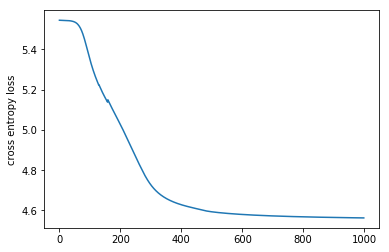

In [9]:
import matplotlib.pyplot as plt
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()